# Contextual Bandits

We will start this notebook with a motivating example.

Let’s face it—ads are annoying. But very often they’re also one of the few ways to keep the business running. Imagine a free-to-play game for example. The real question isn’t whether to show ads, but when and which kind to show, so that players don’t feel bombarded, leave the game frustrated, or stop spending altogether.

It’s a balancing act between monetization and player retention.

If you show ads too aggressively, players quit.
If you show ads too cautiously, you leave money on the table.
So, how do you decide what to do in each moment of a player’s session?

## Turning Ad Scheduling Into a Learning Problem

Every player session is different. Some players are engaged, some are rushing through, some just made a purchase, some are one level away from quitting.

At every possible ad moment, you have choices like:

* Show a **video ad** (high revenue, high interruption)
* Show a **banner ad** (low revenue, low interruption)
* Show **no ad** (defer to later)

And you have *context*—information about the session so far:

* Player’s level and progress
* Time since the last ad
* Time spent in the current session
* Whether the player just succeeded or failed at something
* Recent purchases or reward claims

What you want is a system that **learns from player behavior over time**, figuring out which actions perform best in which contexts—not just maximizing clicks or ad revenue right now, but balancing that with keeping players happy and playing longer.

## Contextual Multi-Armed Bandits to the Rescue

This is exactly where **Contextual Multi-Armed Bandits (CMABs)** come in.

Contextual Multi‑Armed Bandits (CMABs) extend the classic bandit setting by allowing the learner to **observe a context**—a feature vector that describes the current situation—before selecting an action (or *arm*). The learner’s aim is to **maximise cumulative reward** over time by repeatedly balancing:

* **Exploration** – trying arms whose pay‑offs are still uncertain in some contexts.
* **Exploitation** – choosing the arm with the highest estimated reward in the current context.

CMABs sit between simple A/B tests and full reinforcement‑learning problems and are the work‑horse behind many personalisation engines.

Acting *identically* for every context wastes opportunity; CMABs formalise how to adapt decisions on‑the‑fly.

## Implementing CMABs in **RxInfer.jl**

In this notebook we will implement a CMAB in `RxInfer.jl` way.
A way to tackle CMAB in RxInfer requires expressing the generative model as a **hierarchical Bayesian linear‑regression** model and then message passing inference will do the rest.

## Generative model (consistent notation)

Let

* $K$ – number of arms.
* $d$ – dimension of the context vector.
* $c_t\in\mathbb{R}^d$ – context observed at round \$t\$.
* $a_t\in{1,\dots,K}$ – arm selected at round \$t\$.
* $r_t\in\mathbb{R}$ – realised reward.

The environment produces rewards according to:

1. **Global noise precision**
   $$\tau\;\sim\;\mathcal{G}(\alpha_\tau, \beta_\tau)$$
2. **Arm‑specific regression parameters**  $k = 1,\dots,K$
   $$\theta_k \;\sim\; \mathcal{N}(m_{0k}, V_{0k}), \qquad \\ \Lambda_k \;\sim\; \operatorname{Wishart}(\nu_{0k}, W_{0k})$$
3. **Per interaction latent coefficients**  $t = 1,\dots,T$
   $$\beta_t \;\sim\; \mathcal{N}(\theta_{a_t}, \Lambda_{a_t}^{-1})$$
4. **Reward generation**
   $$\mu_t = c_t^\top \beta_t, \qquad \\ r_t \;\sim\; \mathcal{N}(\mu_t, \tau^{-1})$$

**Interpretation.** Each arm owns a *distribution of weight vectors* ($\theta_k$), capturing how the context maps to reward for that arm. On every play we draw a concrete weight vector $\beta_t$, compute the expected reward $\mu_t$, and then observe a noisy realisation $r_t$.

## Inference & decision‑making

With RxInfer we:

1. **Declare** the model above with the `@model` macro. (To make the example simpler, we'll have two models: one for parameters and one for predictions. A more complex scenario would be to have a single model for both.)
2. **Stream** incoming tuples $(c_t, a_t, r_t)$.
3. **Call** `infer` to update the posterior over $(\theta_k, \Lambda_k, \tau)$.
4. **Compute predictive distributions** of rewards in a *new* context $c_{t+1}$ via `infer` on the predictive model:
5. **Choose** the next arm based on sampled from the predictive distribution.

Because both learning and prediction are expressed as probabilistic inference, we keep **all uncertainty** in closed form—ideal for principled exploration. The same pipeline generalises easily to non‑linear contexts (via feature maps) or non‑Gaussian rewards by swapping likelihood terms.


In [1]:
using RxInfer, Distributions, LinearAlgebra, Plots, StatsPlots, ProgressMeter, StableRNGs

At first let's generate synthetic data to simulate the CMAB problem.

In [2]:
# Random number generator 
rng = StableRNG(42)
# Number of data points to generate
n_samples = 200
# Number of arms (actions) in the bandit problem
n_arms    = 3
# Number of different contexts available
n_contexts  = 10
# Dimensionality of context feature vectors
context_dim = 6

# Generate true arm parameters (θ_k in the model description)
arms     = [ randn(rng, context_dim) for _ in 1:n_arms] # True arm parameters
# Generate (normalized) context feature vectors (x_t in the model description)
contexts = [ randn(rng, context_dim) for _ in 1:n_contexts] # Context feature vectors

# Standard deviation of the observation noise (1/sqrt(τ) in the model)
noise_sd = 0.1

# Arrays to store the generated data
arm_choices     = [] # Stores a_t - which arm was chosen
context_choices = [] # Stores indices of contexts used
rewards         = [] # Stores r_t - the observed rewards

# Generate synthetic data according to the model
for i in 1:n_samples
    # Randomly select a context and an arm
    push!(context_choices, rand(rng, 1:n_contexts))
    push!(arm_choices,     rand(rng, 1:n_arms))
    
    # Calculate the deterministic part of the reward (μ_t = x_t^T β_t)
    # Here we're simplifying by using arms directly as β_t instead of sampling from N(θ_k, Λ_k^-1)
    mean_reward = dot(arms[arm_choices[end]], contexts[context_choices[end]])
    
    # Add Gaussian noise (r_t ~ N(μ_t, τ^-1))
    noisy_reward = mean_reward + randn(rng) * noise_sd
    push!(rewards, noisy_reward)
end

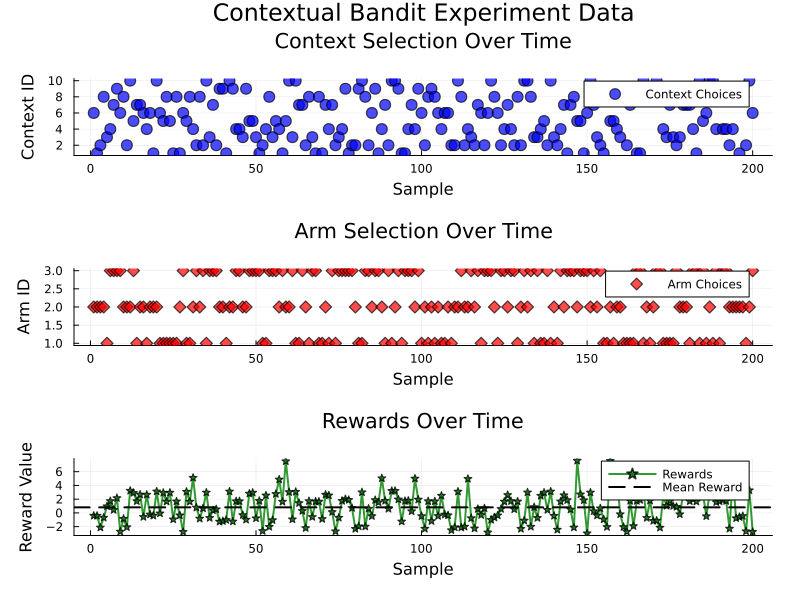

In [3]:
# Create more informative and visually appealing plots
p1 = scatter(1:n_samples, context_choices, 
             label="Context Choices", 
             title="Context Selection Over Time",
             xlabel="Sample", ylabel="Context ID",
             marker=:circle, markersize=6, 
             color=:blue, alpha=0.7,
             legend=:topright)

p2 = scatter(1:n_samples, arm_choices, 
             label="Arm Choices", 
             title="Arm Selection Over Time",
             xlabel="Sample", ylabel="Arm ID",
             marker=:diamond, markersize=6, 
             color=:red, alpha=0.7,
             legend=:topright)

p3 = plot(1:n_samples, rewards, 
          label="Rewards", 
          title="Rewards Over Time",
          xlabel="Sample", ylabel="Reward Value",
          linewidth=2, marker=:star, markersize=4, 
          color=:green, alpha=0.8,
          legend=:topright)

# Add a horizontal line at mean reward
hline!(p3, [mean(rewards)], label="Mean Reward", linestyle=:dash, linewidth=2, color=:black)

# Combine plots with a title
plot(p1, p2, p3, 
     layout=(3, 1), 
     size=(800, 600), 
     margin=5Plots.mm,
     plot_title="Contextual Bandit Experiment Data")

In [4]:
@model function contextual_bandit_simplified(n_arms, priors, past_rewards, past_choices, past_contexts)
    local θ
    local γ
    local τ
    
    # Prior for each arm's parameters
    for k in 1:n_arms
        θ[k] ~ priors[:θ][k]
        γ[k] ~ priors[:γ][k]
    end

    # Prior for the noise precision
    τ ~ priors[:τ]

    # Model for past observations
    for n in eachindex(past_rewards)
        arm_vals[n] ~ NormalMixture(switch = past_choices[n], m = θ, p = γ)
        past_rewards[n] ~ Normal(μ=dot(arm_vals[n], past_contexts[n]), γ=τ)
    end
end

Let's define the priors.

In [5]:
priors_rng = StableRNG(42)
priors = Dict(
    :θ => [MvNormalMeanPrecision(randn(priors_rng, context_dim), diagm(ones(context_dim))) for _ in 1:n_arms], 
    :γ => [Wishart(context_dim + 1, diagm(ones(context_dim))) for _ in 1:n_arms], 
    :τ => GammaShapeRate(1.0, 1.0)
)

Dict{Symbol, Any} with 3 entries:
  :γ => Wishart{Float64, PDMat{Float64, Matrix{Float64}}, Int64}[Wishart{Float6…
  :τ => GammaShapeRate{Float64}(a=1.0, b=1.0)
  :θ => MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNorm…

And finally run the inference.

In [6]:
function run_inference(; n_arms, priors, past_rewards, past_choices, past_contexts, iterations = 50, free_energy = true)
    init = @initialization begin
        q(θ) = priors[:θ]
        q(γ) = priors[:γ]
        q(τ) = priors[:τ]
    end

    return infer(
        model = contextual_bandit_simplified(
            n_arms = n_arms, 
            priors = priors,
        ), 
        data  = (
            past_rewards  = past_rewards, 
            past_choices  = past_choices, 
            past_contexts = past_contexts
        ), 
        constraints   = MeanField(),
        initialization = init,
        showprogress = true, 
        iterations  = iterations, 
        free_energy = free_energy
    )

end

run_inference (generic function with 1 method)

In [7]:
# Convert to the required types for the model
rewards_data = Float64.(rewards)
contexts_data = Vector{Float64}[contexts[idx] for idx in context_choices]
arm_choices_data = [[Float64(k == chosen_arm) for k in 1:n_arms] for chosen_arm in arm_choices];

In [8]:
result = run_inference(
    n_arms = n_arms, 
    priors = priors, 
    past_rewards = rewards_data, 
    past_choices = arm_choices_data, 
    past_contexts = contexts_data, 
    iterations = 50, 
    free_energy = false
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Inference results:
  Posteriors       | available for (γ, arm_vals, τ, θ)


In [9]:
# Diagnostics of inferred arms

# MSE of inferred arms
mse_arms = mean(mean((mean.(result.posteriors[:θ][end])[i] .- arms[i]).^2) for i in eachindex(arms))
println("MSE of inferred arms: $mse_arms")

println("True mean rewards:")
println(arms[1]'*contexts[1])
println(arms[2]'*contexts[2])
println(arms[1]'*contexts[2])
println(arms[2]'*contexts[1])
println("Inferred mean rewards:")
println(mean.(result.posteriors[:θ][end])[1]'*contexts[1])
println(mean.(result.posteriors[:θ][end])[2]'*contexts[2])
println(mean.(result.posteriors[:θ][end])[1]'*contexts[2])
println(mean.(result.posteriors[:θ][end])[2]'*contexts[1])

println("Precisions of mixtures:")
println(repr(MIME"text/plain"(), mean(result.posteriors[:γ][end][1])))
println(repr(MIME"text/plain"(), mean(result.posteriors[:γ][end][2])))


MSE of inferred arms: 0.0003125825950642141
True mean rewards:
-0.9579669881184844
-2.282584691329295
-2.683794982728294
-0.36962426435196233
Inferred mean rewards:
-0.9833867148306223
-2.2365081642253037
-2.6599445159029367
-0.3743693401277671
Precisions of mixtures:
6×6 Matrix{Float64}:
 11.7926     1.23996   1.80025     -1.97843    1.74577      0.488932
  1.23996   14.6716   -3.55382      1.20452   -1.29646      2.52028
  1.80025   -3.55382  14.5377      -1.17817    0.00595107  -1.9205
 -1.97843    1.20452  -1.17817     17.5505    -0.451869     2.82889
  1.74577   -1.29646   0.00595107  -0.451869  11.8356       0.420977
  0.488932   2.52028  -1.9205       2.82889    0.420977    14.2777
6×6 Matrix{Float64}:
 11.9552    1.07416    2.07428   -1.10233    1.98604    1.1934
  1.07416  15.8296    -3.3471     0.689648  -3.07965    2.3066
  2.07428  -3.3471    14.2365    -0.211613   1.10734   -1.15906
 -1.10233   0.689648  -0.211613  18.5433    -0.603242   2.52572
  1.98604  -3.07965    1.10

### Comparing Different Strategies for the Contextual Bandit Problem
We'll implement and evaluate three different approaches:

1. Random Strategy - Selecting arms randomly without using context information
2. Vanilla Thompson Sampling - Sampling the reward distribution
3. RxInfer Predictive Inference - Approximating the predictive posterior via message-passing


In [10]:
function random_strategy(; rng, n_arms)
    chosen_arm = rand(rng, 1:n_arms)
    return chosen_arm
end

function thompson_strategy(; rng, n_arms, current_context, posteriors)
    # Thompson Sampling: Sample parameter vectors and choose best arm
    expected_rewards = zeros(n_arms)
    for k in 1:n_arms
        # Sample parameters from posterior
        theta_sample = rand(rng, posteriors[:θ][k])
        expected_rewards[k] = dot(theta_sample, current_context)
    end
    
    # Choose best arm based on sampled parameters
    chosen_arm = argmax(expected_rewards)

    # Randomly choose an arm with 20% probability to explore
    if rand(rng) < 0.20
        chosen_arm = rand(rng, 1:n_arms)
    end

    return chosen_arm
end

thompson_strategy (generic function with 1 method)

In [11]:
@model function contextual_bandit_predictive(reward, priors, current_context)
    local θ
    local γ
    local τ

    # Prior for each arm's parameters
    for k in 1:n_arms
        θ[k] ~ priors[:θ][k]
        γ[k] ~ priors[:γ][k]
    end

    τ ~ priors[:τ]

    chosen_arm ~ Categorical(ones(n_arms) ./ n_arms)
    arm_vals ~ NormalMixture(switch=chosen_arm, m=θ, p=γ)
    reward ~ Normal(μ=dot(arm_vals, current_context), γ=τ)
end

function predictive_strategy(; rng, n_arms, current_context, posteriors)

    priors = Dict(
        :θ => posteriors[:θ],
        :γ => posteriors[:γ],
        :τ => posteriors[:τ]
    )

    init = @initialization begin
        q(θ) = priors[:θ]
        q(τ) = priors[:τ]
        q(γ) = priors[:γ]
        q(chosen_arm) = Categorical(ones(n_arms) ./ n_arms)
    end

    result = infer(
        model=contextual_bandit_predictive(
            priors=priors,
            current_context=current_context
        ),
        data=(reward=maximum(rewards),),
        constraints=MeanField(),
        initialization=init,
        showprogress=true,
        iterations=50,
    )

    chosen_arm = argmax(probvec(result.posteriors[:chosen_arm][end]))

    return chosen_arm
end

predictive_strategy (generic function with 1 method)

As we defined the strategies, we can proceed to defining the helper functions to run the simulation.

We will use the following flow:
1. **PLAN** - Run different strategies
2. **ACT** - In this simulation, we're evaluating all strategies in parallel
3. **OBSERVE** - Get rewards for all strategies
4. **LEARN** - Update posteriors based on history
5. **KEEP HISTORY** - Record all results

In [12]:
# Helper functions
function select_context(rng, n_contexts)
    idx = rand(rng, 1:n_contexts)
    return (index = idx, value = contexts[idx])
end

function plan(rng, n_arms, context, posteriors)
    # Generate actions from different strategies
    return Dict(
        :random => random_strategy(rng = rng, n_arms = n_arms),
        :thompson => thompson_strategy(rng = rng, n_arms = n_arms, current_context = context, posteriors = posteriors),
        :predictive => predictive_strategy(rng = rng, n_arms = n_arms, current_context = context, posteriors = posteriors)
    )
end

function act(rng, strategies)
    # Here one would choose which strategy to actually follow
    # For this simulation, we're evaluating all in parallel
    # In a real scenario, one might return just one: return strategies[:thompson]
    return strategies
end

function observe(rng, strategies, context, arms, noise_sd)
    rewards = Dict()
    for (strategy, arm_idx) in strategies
        rewards[strategy] = dot(arms[arm_idx], context) + randn(rng) * noise_sd
    end
    return rewards
end

function learn(rng, n_arms, posteriors, past_rewards, past_choices, past_contexts)
    # Note that we don't do any forgetting here which might be useful for long-term learning
    # Prepare priors from current posteriors
    priors = Dict(:θ => posteriors[:θ], :τ => posteriors[:τ], :γ => posteriors[:γ])
    
    # Default initialization
    init = @initialization begin
        q(θ) = priors[:θ]
        q(τ) = priors[:τ]
        q(γ) = priors[:γ]
    end
    
    # Run inference
    results = infer(
        model = contextual_bandit_simplified(
            n_arms = n_arms, 
            priors = priors,
        ), 
        data = (
            past_rewards = past_rewards, 
            past_choices = past_choices,
            past_contexts = past_contexts, 
        ), 
        returnvars = KeepLast(),
        constraints = MeanField(),
        initialization = init,
        iterations = 50, 
        free_energy = false
    )
    
    return results.posteriors
end

function keep_history!(n_arms, history, strategies, rewards, context, posteriors)
    # Update choices
    for (strategy, arm_idx) in strategies
        push!(history[:choices][strategy], [Float64(k == arm_idx) for k in 1:n_arms])
    end
    
    # Update rewards
    for (strategy, reward) in rewards
        push!(history[:rewards][strategy], reward)
    end
    
    # Update real history - using predictive strategy as the actual choice
    push!(history[:real][:rewards], last(history[:rewards][:predictive]))
    push!(history[:real][:choices], last(history[:choices][:predictive]))
    
    # Update contexts
    push!(history[:contexts][:values], context.value)
    push!(history[:contexts][:indices], context.index)
    
    # Update posteriors
    push!(history[:posteriors], deepcopy(posteriors))
end

keep_history! (generic function with 1 method)

In [13]:
function run_bandit_simulation(n_epochs, window_length, n_arms, n_contexts, context_dim)
    rng = StableRNG(42)

    # Initialize histories with empty arrays, removing the references to undefined variables
    history = Dict(
        :rewards => Dict(:random => [], :thompson => [], :predictive => []),
        :choices => Dict(:random => [], :thompson => [], :predictive => []),
        :real => Dict(:rewards => [], :choices => []),
        :contexts => Dict(:values => [], :indices => []),
        :posteriors => []
    )

    # Initialize prior posterior as uninformative 
    posteriors = Dict(:θ => [MvNormalMeanPrecision(randn(rng, context_dim), diagm(ones(context_dim))) for _ in 1:n_arms], 
                      :γ => [Wishart(context_dim + 1, diagm(ones(context_dim))) for _ in 1:n_arms], 
                      :τ => GammaShapeRate(1.0, 1.0))

    @showprogress for epoch in 1:n_epochs
        # 1. PLAN - Run different strategies
        current_context = select_context(rng, n_contexts)

        strategies = plan(rng, n_arms, current_context.value, posteriors)
        
        # 2. ACT - In this simulation, we're evaluating all strategies in parallel
        # In a real scenario, you might choose one strategy here
        chosen_arm = act(rng, strategies)
        
        # 3. OBSERVE - Get rewards for all strategies
        rewards = observe(rng, strategies, current_context.value, arms, noise_sd)
        
        # 4. LEARN - Update posteriors based on history
        # Only try to learn if we have collected data
        if length(history[:real][:rewards]) > 0
            data_idx = max(1, length(history[:real][:rewards]) - window_length + 1):length(history[:real][:rewards])
            
            posteriors = learn(
                rng,
                n_arms,
                posteriors,
                history[:real][:rewards][data_idx],
                history[:real][:choices][data_idx],
                history[:contexts][:values][data_idx]
            )

        end
        
        # 5. KEEP HISTORY - Record all results
        keep_history!(n_arms, history, strategies, rewards, current_context, posteriors)
    end
    
    return history
end

run_bandit_simulation (generic function with 1 method)

In [14]:
# Run the simulation
n_epochs = 500
window_length = 10

history = run_bandit_simulation(n_epochs, window_length, n_arms, n_contexts, context_dim)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Dict{Symbol, Any} with 5 entries:
  :choices    => Dict{Symbol, Vector{Any}}(:predictive=>[[1.0, 0.0, 0.0], [1.0,…
  :contexts   => Dict{Symbol, Vector{Any}}(:values=>[[1.13363, -0.840372, 2.085…
  :real       => Dict{Symbol, Vector{Any}}(:choices=>[[1.0, 0.0, 0.0], [1.0, 0.…
  :rewards    => Dict{Symbol, Vector{Any}}(:predictive=>[-1.03096, 1.03581, 3.0…
  :posteriors => Any[Dict{Symbol, Any}(:γ=>Wishart{Float64, PDMat{Float64, Matr…

In [15]:
function print_summary_statistics(history, n_epochs)
    # Additional summary statistics
    println("Random strategy cumulative reward: $(sum(history[:rewards][:random]))")
    println("Thompson strategy cumulative reward: $(sum(history[:rewards][:thompson]))")
    println("Predictive strategy cumulative reward: $(sum(history[:rewards][:predictive]))")

    println("Results after $n_epochs epochs:")
    println("Random strategy average reward: $(mean(history[:rewards][:random]))")
    println("Thompson strategy average reward: $(mean(history[:rewards][:thompson]))")
    println("Predictive strategy average reward: $(mean(history[:rewards][:predictive]))")
end

# Print the summary statistics
print_summary_statistics(history, n_epochs)

Random strategy cumulative reward: 285.4372425759371
Thompson strategy cumulative reward: 1002.793995347213
Predictive strategy cumulative reward: 1066.9597510701233
Results after 500 epochs:
Random strategy average reward: 0.5708744851518742
Thompson strategy average reward: 2.005587990694426
Predictive strategy average reward: 2.1339195021402464


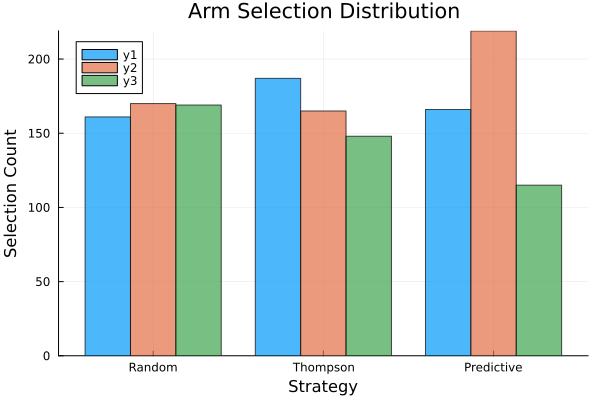

In [16]:
function plot_arm_distribution(history, n_arms)
    # Count frequency of each arm selection
    arm_counts_random = [count(==(i), argmax.(history[:choices][:random])) for i in 1:n_arms]
    arm_counts_thompson = [count(==(i), argmax.(history[:choices][:thompson])) for i in 1:n_arms]
    arm_counts_predictive = [count(==(i), argmax.(history[:choices][:predictive])) for i in 1:n_arms]

    # Create grouped bar plot
    bar_plot = groupedbar(
        ["Random", "Thompson", "Predictive"],
        [arm_counts_random arm_counts_thompson arm_counts_predictive]',
        title="Arm Selection Distribution",
        xlabel="Strategy",
        ylabel="Selection Count",
        bar_position=:dodge,
        bar_width=0.8,
        alpha=0.7
    )
    
    return bar_plot
end

# Plot arm distribution
arm_distribution_plot = plot_arm_distribution(history, n_arms)
display(arm_distribution_plot)

In [17]:
function calculate_improvements(history)
    # Get final average rewards
    final_random_avg = mean(history[:rewards][:random])
    final_thompson_avg = mean(history[:rewards][:thompson])
    final_predictive_avg = mean(history[:rewards][:predictive])

    # Improvements over random baseline
    thompson_improvement = (final_thompson_avg - final_random_avg) / abs(final_random_avg) * 100
    predictive_improvement = (final_predictive_avg - final_random_avg) / abs(final_random_avg) * 100

    println("Thompson sampling improves over random by $(round(thompson_improvement, digits=2))%")
    println("Predictive strategy improves over random by $(round(predictive_improvement, digits=2))%")
    
    return Dict(
        :thompson => thompson_improvement,
        :predictive => predictive_improvement
    )
end

# Calculate and display improvements
improvements = calculate_improvements(history)

Thompson sampling improves over random by 251.32%
Predictive strategy improves over random by 273.8%


Dict{Symbol, Float64} with 2 entries:
  :predictive => 273.798
  :thompson   => 251.319

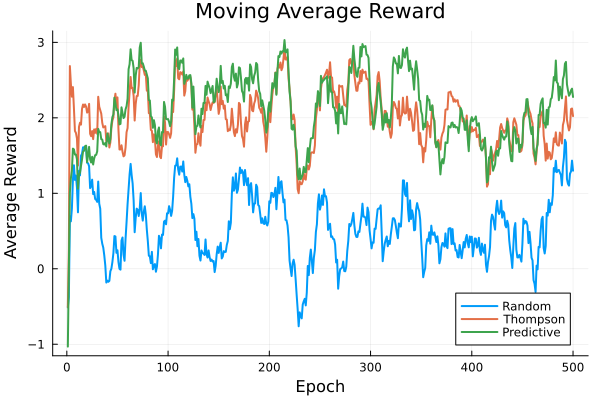

In [18]:
function plot_moving_averages(history, n_epochs, ma_window=20)
    # Calculate moving average rewards
    ma_rewards_random = [mean(history[:rewards][:random][max(1,i-ma_window+1):i]) for i in 1:n_epochs]
    ma_rewards_thompson = [mean(history[:rewards][:thompson][max(1,i-ma_window+1):i]) for i in 1:n_epochs]
    ma_rewards_predictive = [mean(history[:rewards][:predictive][max(1,i-ma_window+1):i]) for i in 1:n_epochs]

    # Plot moving average
    plot(1:n_epochs, [ma_rewards_random, ma_rewards_thompson, ma_rewards_predictive], 
         label=["Random" "Thompson" "Predictive"],
         title="Moving Average Reward", 
         xlabel="Epoch", ylabel="Average Reward",
         lw=2)
end

# Plot moving averages
plot_moving_averages(history, n_epochs)

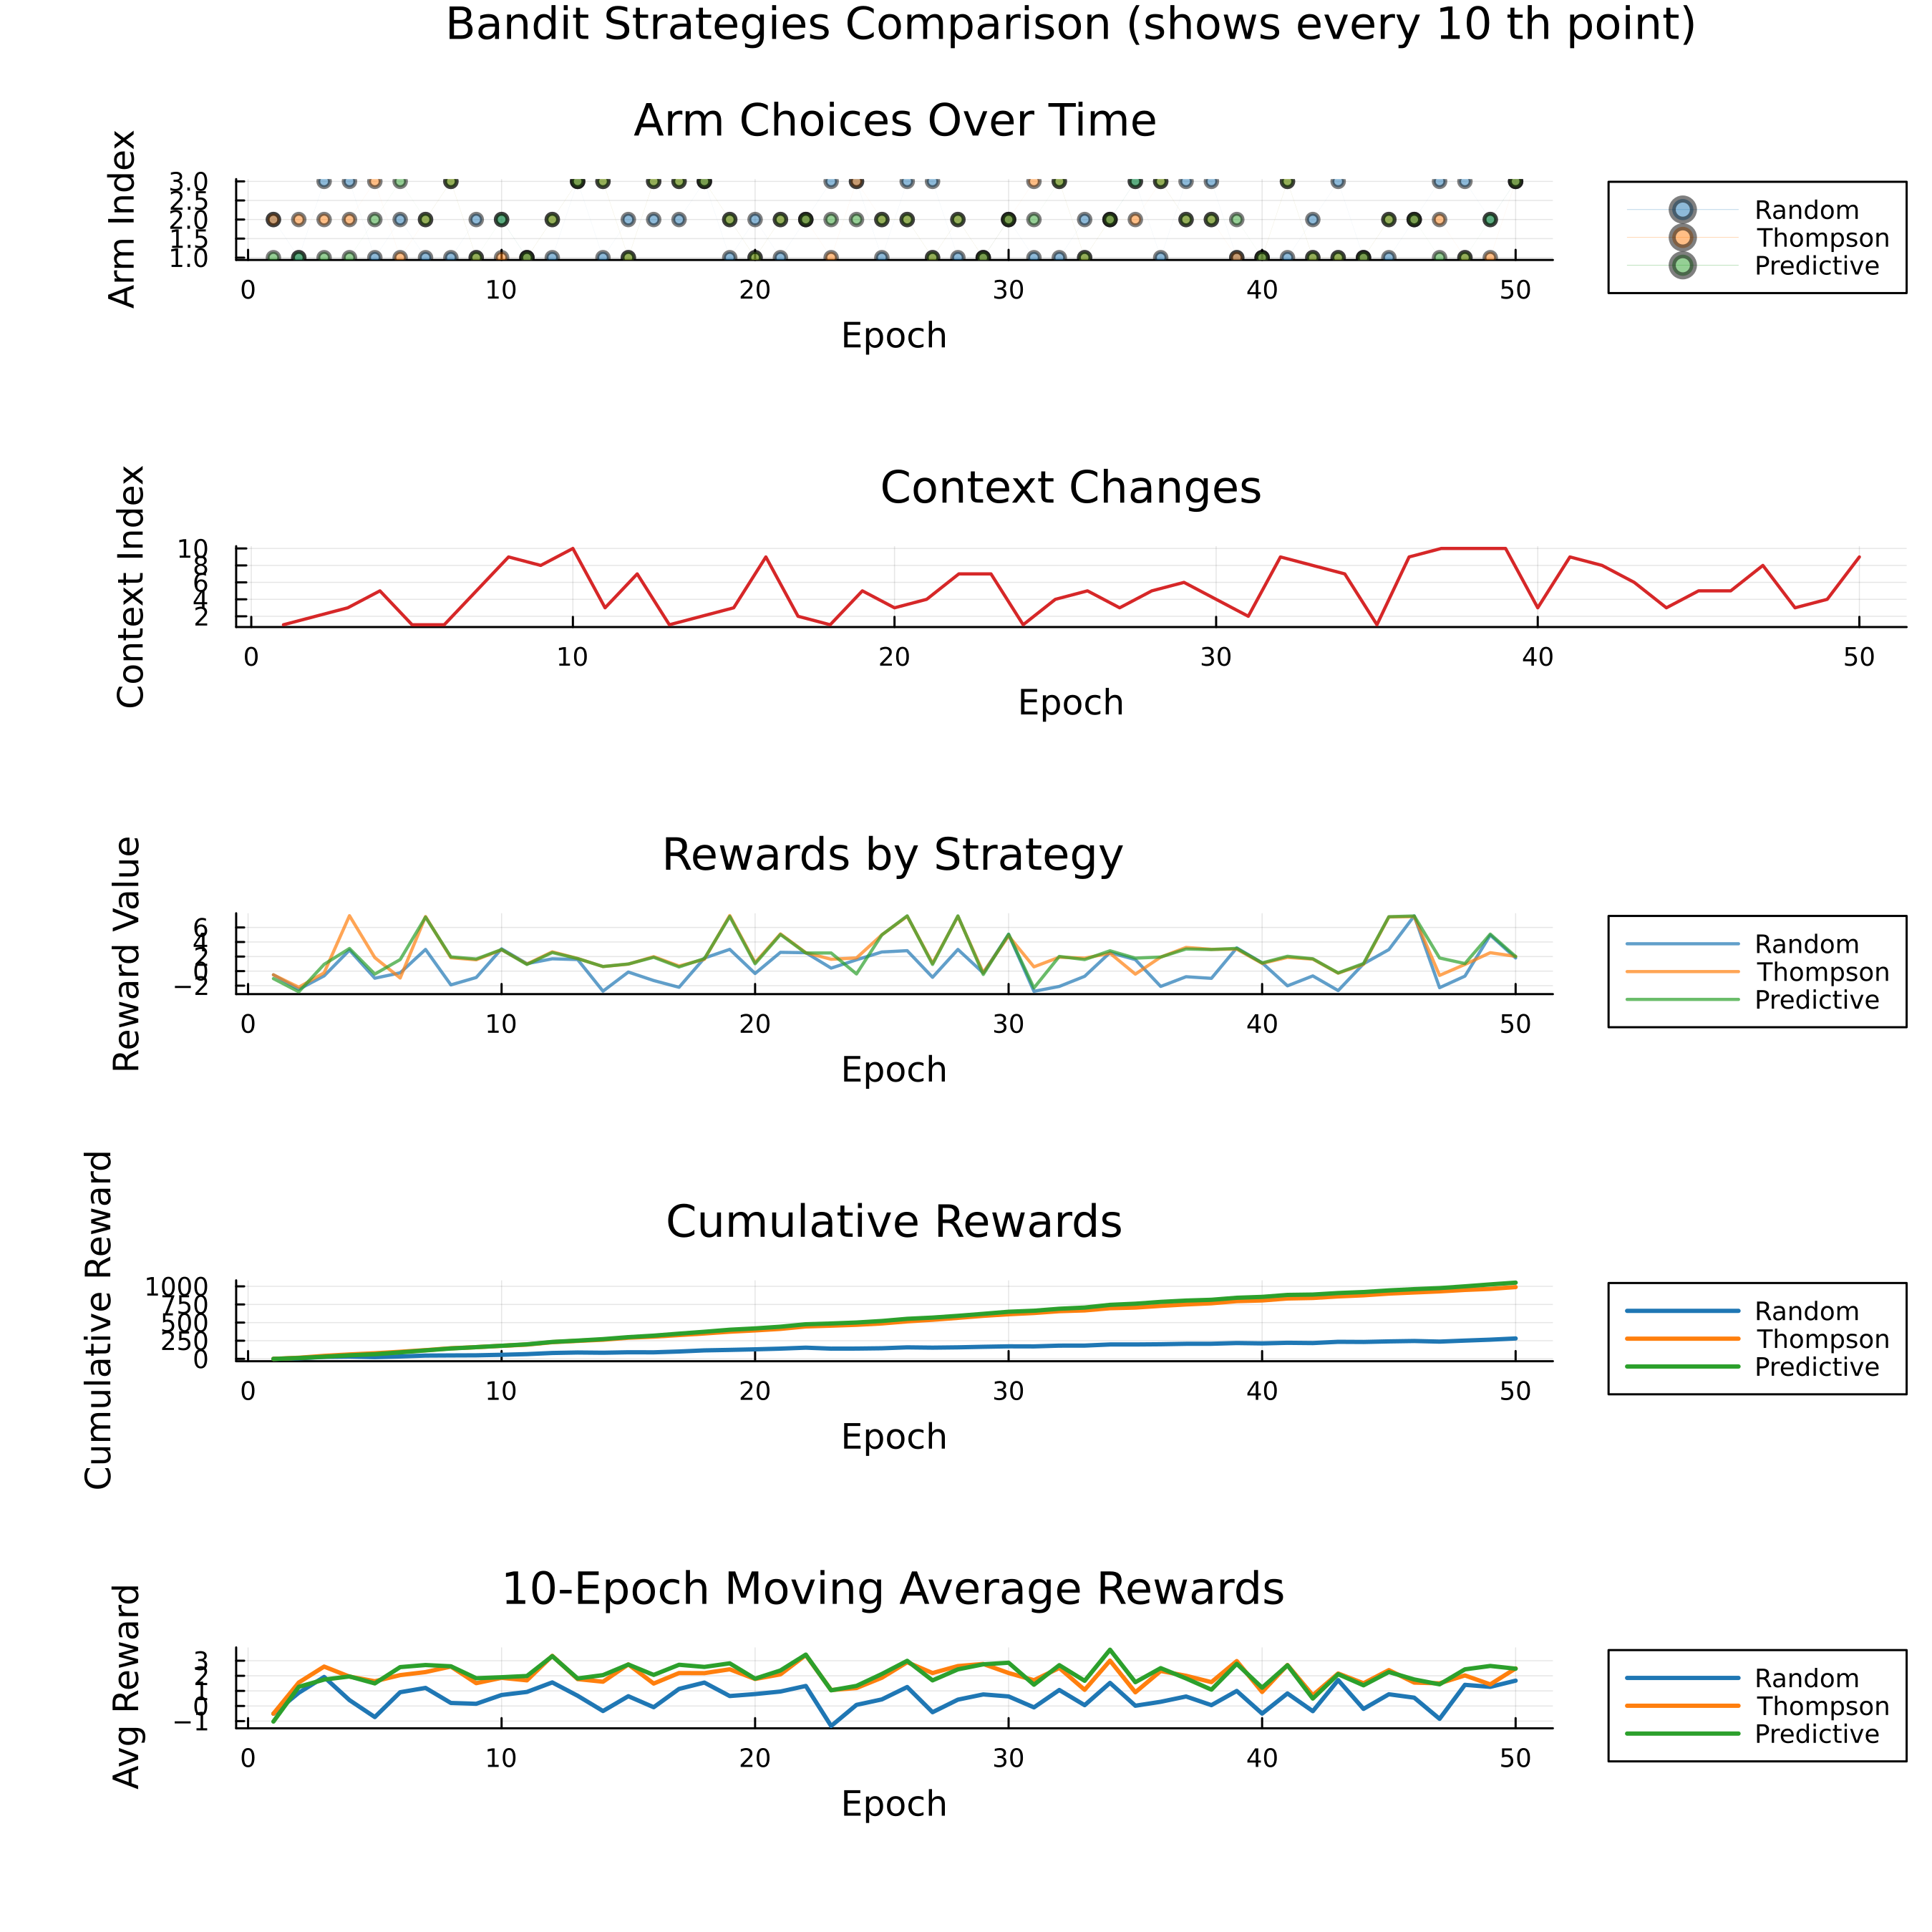

In [19]:
function create_comprehensive_plots(history, window=100, k=10)
    # Create a better color palette
    colors = palette(:tab10)

    # Plot 1: Arm choices comparison (every k-th point)
    p1 = plot(title="Arm Choices Over Time", xlabel="Epoch", ylabel="Arm Index", 
              legend=:outertopright, dpi=300)
    plot!(p1, argmax.(history[:choices][:random][1:k:end]), label="Random", color=colors[1], 
          markershape=:circle, markersize=3, alpha=0.5, linewidth=0)
    plot!(p1, argmax.(history[:choices][:thompson][1:k:end]), label="Thompson", color=colors[2], 
          markershape=:circle, markersize=3, alpha=0.5, linewidth=0)
    plot!(p1, argmax.(history[:choices][:predictive][1:k:end]), label="Predictive", color=colors[3], 
          markershape=:circle, markersize=3, alpha=0.5, linewidth=0)

    # Plot 2: Context values (every k-th point)
    p2 = plot(title="Context Changes", xlabel="Epoch", ylabel="Context Index", 
              legend=false, dpi=300)
    plot!(p2, history[:contexts][:indices][1:k:end], color=colors[4], linewidth=1.5)

    # Plot 3: Reward comparison (every k-th point)
    p3 = plot(title="Rewards by Strategy", xlabel="Epoch", ylabel="Reward Value", 
              legend=:outertopright, dpi=300)
    plot!(p3, history[:rewards][:random][1:k:end], label="Random", color=colors[1], linewidth=1.5, alpha=0.7)
    plot!(p3, history[:rewards][:thompson][1:k:end], label="Thompson", color=colors[2], linewidth=1.5, alpha=0.7)
    plot!(p3, history[:rewards][:predictive][1:k:end], label="Predictive", color=colors[3], linewidth=1.5, alpha=0.7)

    # Plot 4: Cumulative rewards (every k-th point)
    cumul_random = cumsum(history[:rewards][:random])[1:k:end]
    cumul_thompson = cumsum(history[:rewards][:thompson])[1:k:end]
    cumul_predictive = cumsum(history[:rewards][:predictive])[1:k:end]

    p4 = plot(title="Cumulative Rewards", xlabel="Epoch", ylabel="Cumulative Reward", 
              legend=:outertopright, dpi=300)
    plot!(p4, cumul_random, label="Random", color=colors[1], linewidth=2)
    plot!(p4, cumul_thompson, label="Thompson", color=colors[2], linewidth=2)
    plot!(p4, cumul_predictive, label="Predictive", color=colors[3], linewidth=2)

    # Plot 5: Moving average rewards (every k-th point)
    ma_random = [mean(history[:rewards][:random][max(1,i-window+1):i]) for i in 1:length(history[:rewards][:random])][1:k:end]
    ma_thompson = [mean(history[:rewards][:thompson][max(1,i-window+1):i]) for i in 1:length(history[:rewards][:thompson])][1:k:end]
    ma_predictive = [mean(history[:rewards][:predictive][max(1,i-window+1):i]) for i in 1:length(history[:rewards][:predictive])][1:k:end]

    p5 = plot(title="$window-Epoch Moving Average Rewards", xlabel="Epoch", ylabel="Avg Reward", 
              legend=:outertopright, dpi=300)
    plot!(p5, ma_random, label="Random", color=colors[1], linewidth=2)
    plot!(p5, ma_thompson, label="Thompson", color=colors[2], linewidth=2)
    plot!(p5, ma_predictive, label="Predictive", color=colors[3], linewidth=2)

    # Combine all plots with a title
    combined_plot = plot(p1, p2, p3, p4, p5, 
         layout=(5, 1), 
         size=(900, 900), 
         plot_title="Bandit Strategies Comparison (shows every $k th point)", 
         plot_titlefontsize=14,
         left_margin=10Plots.mm,
         bottom_margin=10Plots.mm)
         
    return combined_plot
end

create_comprehensive_plots(history, window_length, 10)  # Using k=10 for prettier plots

Thompson and Predictive strategies both significantly outperform Random. Both intelligent strategies quickly adapt to changing contexts. The Predictive strategy shows a slight edge over Thompson sampling in final performance, demonstrating the effectiveness of Bayesian approaches in sequential decision-making under uncertainty.